In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import dill
import sys
import time
from joblib import Parallel, delayed
import scipy.stats as sct
sys.path.append("modules")
from stn import stnStruct
import deg

In [2]:
with open("biondiRstruct.dat", "rb") as dill_file:
    stn = dill.load(dill_file)

In [3]:
res = pd.read_pickle("/home/jw3617/STN/results_Sonly_LHS_allunits/results.pkl")
#res = res.loc[res["infeasible"] == False]

In [167]:
def get_hist(df, col):
    table = pd.DataFrame.from_dict(Counter(df[col]), orient="index")
    table = table.rename(columns={0:"count"})
    table["p"] = table["count"]/sum(table["count"])
    print(df.shape)
    return table

def get_trans_prob(df, i, j):
    dfj = df.loc[df["unit"] == j,].copy()
    dfj["taskmode-1"] = dfj["taskmode"].shift(-1)
    dfj.loc[pd.isna(dfj["taskmode-1"]),"taskmode-1"] = "None-None"
    #df = df.loc[df["Product_1"] >= 200]
    #df = df.loc[df["Product_2"] <= 150]
    if np.any(dfj["taskmode"] == i):
        table = get_hist(dfj[dfj["taskmode"] == i], "taskmode-1")
    else:
        table = get_hist(dfj[dfj["taskmode"] == "None-None"], "taskmode-1")
    return table

In [594]:
prof = pd.read_pickle("/home/jw3617/STN/results_Sonly_LHS_200/profile.pkl")
prof["taskmode"] = [row["task"] + "-" + row["mode"] for i, row in prof.iterrows()]
prof = prof[prof["id"].isin(res["ID"])]
#df2 = prof.loc[prof["Product_1"] >= 200,]
#df3 = df2.loc[df2["Product_2"] <= 150]
#get_trans_prob(df2, "Reaction_1-Slow")

In [535]:
from sklearn import linear_model

def get_logreg(prof, i, j):
    dfj = prof.loc[prof["unit"] == j,].copy()
    dfj["taskmode-1"] = dfj["taskmode"].shift(-1)
    dfj.loc[pd.isna(dfj["taskmode-1"]),"taskmode-1"] = "None-None"
    dfj = dfj[dfj["taskmode"] == i]
    if dfj.shape[0] > 0 and len(np.unique(dfj["taskmode-1"])) > 1:
        X = np.array(dfj[prods])
        Y = np.array(dfj["taskmode-1"])
        logreg = linear_model.LogisticRegression(multi_class="multinomial", solver="lbfgs", verbose=0, max_iter=10000)
        logreg.fit(X,Y)
        return logreg
    elif dfj.shape[0] > 0:
        return np.array(dfj["taskmode-1"])[0]
    else:
        return "None-None"
    
def get_trans_prob_logreg(prof, i, j, prods, demands):
    dfj = prof.loc[prof["unit"] == j,].copy()
    dfj["taskmode-1"] = dfj["taskmode"].shift(-1)
    dfj.loc[pd.isna(dfj["taskmode-1"]),"taskmode-1"] = "None-None"
    dfj = dfj[dfj["taskmode"] == i]
    if dfj.shape[0] > 0 and len(np.unique(dfj["taskmode-1"])) > 1:
        X = np.array(dfj[prods])
        Y = np.array(dfj["taskmode-1"])
        logreg = linear_model.LogisticRegression(multi_class="multinomial", solver="lbfgs", verbose=0, max_iter=10000)
        logreg.fit(X,Y)
        table = pd.DataFrame(logreg.predict_proba([demands]), columns=logreg.classes_)
    elif dfj.shape[0] > 0:
        table = pd.DataFrame([1], columns=[np.array(dfj["taskmode-1"])[0]])
    else:
        table = pd.DataFrame([1], columns=["None-None"])
    return table
#table["Separation-Slow"]

j = "Reactor_1"
i = "Reaction_1-Normal"
prods = ["Product_1","Product_2"]
demands = [50,100]
lr = get_logreg(prof, i, j)
table = pd.DataFrame(lr.predict_proba([demands]), columns=lr.classes_)
table

,None-None,Reaction_1-Normal,Reaction_1-Slow,Reaction_2-Fast,Reaction_2-Normal,Reaction_2-Slow,Reaction_3-Fast,Reaction_3-Slow
0,0.003537,0.008765,0.001047,0.002439,0.033076,0.9476,0.000076,0.00346


In [157]:
df2 = prof.loc[prof["Product_1"] >= 200,].copy()
df3 = df2.loc[df2["Product_2"] >= 300,].copy()

'None-None'

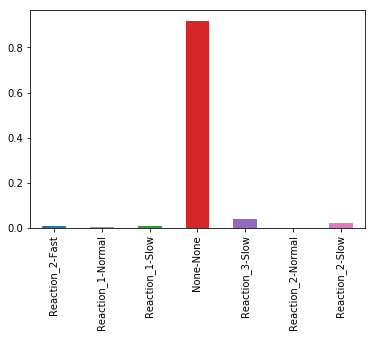

In [42]:
table = get_trans_prob(prof, "M-M", "Reactor_2")
table["p"].plot(kind="bar")
table
table.index.tolist()[np.where(np.random.uniform() < np.cumsum(table["p"]))[0][0]]

In [568]:
def simulate_mc(TP, stn, j, s0, T, dTs, dTp, prods, demand, eps):
    mc = []
    s = s0
    Rmax = stn.Rmax[j]
    Rinit = stn.Rinit[j]
    R = Rinit
    Rlist = []
    if s == "None-None":
        t = dTs
    elif s == "M-M":
        t = stn.tau[j]
    else:
        i, k = s.split("-")
        t = stn.p[i, j, k]
    tlist = []
    D = {"None-None":0, "M-M":0}
    for i in stn.I[j]:
        for k in stn.O[j]:
            D.update({i+"-"+k:stn.D[i,j,k]*(1+eps)})
    while t < T:   
        mc.append(s)
        Rlist.append(R)
        tlist.append(t)
        #table = get_trans_prob(prof, s, j)
        logreg = TP[j, s]
        if type(logreg) == str:
            table = pd.DataFrame([1], columns=[logreg])
        else:
            table = pd.DataFrame(logreg.predict_proba([[d[t // dTp] for d in demand]]), columns=logreg.classes_)
        while True:            
            #s = table.index.tolist()[np.where(np.random.uniform() < np.cumsum(table["P"]))[0][0]]
            s_ind = np.where(np.random.uniform() < np.cumsum(table, axis=1))[1][0]
            s = table.columns[s_ind]
            if s != "M-M":
                break
        R = R + D[s]
        if R > Rmax:
            s = "M-M"
            R = 0        
        if s == "None-None":
            t += dTs
        elif s == "M-M":
            t += stn.tau[j]
        else:
            i, k = s.split("-")
            t += stn.p[i, j, k]
    return mc, Rlist, tlist


In [387]:
def get_deg_profile(profile, stn, j, dT, dt=1/10, N=1, Sinit=0, S0=0):
    Ns = int(len(profile)*dT/dt)
    Darr = np.zeros((3, 0))
    t = 0
    for taskmode in profile:
        m = 0
        mue = 0
        sd = 0.05*np.sqrt(dt)
        if taskmode == "None-None":
            tend = t + dT            
        elif taskmode == "M-M":
            tend = t + stn.tau[j]
            sd = 0
            m = 1
        else:
            s = taskmode.split("-")
            i = s[0]
            k = s[1]
            tend = t + stn.p[i,j,k]
            mue = stn.D[i,j,k]*dt/stn.p[i,j,k]
            sd = 0.27*mue/(np.sqrt(dt/stn.p[i,j,k]))
        tend = int(tend)
        np.array([[1, 2],[3,4]])
        #print(len([m]+[0 for i in range(int(t/dt)+1, int(tend/dt))]))
        #print(len([mue for i in range(int(t/dt), int(tend/dt))]))
        #print(t/dt)
        
        Darr = np.concatenate((Darr, 
                        np.array([
                            [mue for i in range(int(t/dt), int(tend/dt))],
                            [sd for i in range(int(t/dt), int(tend/dt))],
                            [m]+[0 for i in range(int(t/dt)+1, int(tend/dt))]])),
                       axis=1)
        t = tend
    return Darr

# Darr = get_deg_profile(mc, stn, "Reactor_1", 3, dt=1)





In [388]:
def get_time_profile(mc, stn, j, dt):
    profile = []
    t = 0
    for taskmode in mc:
        if taskmode == "None-None":
            tend = t + dt
        elif taskmode == "M-M":
            tend = t + stn.tau[j]
        else:
            s = taskmode.split("-")
            i = s[0]
            k = s[1]
            tend = t + stn.p[i,j,k]
        profile += [taskmode for i in range(t, tend, dt)]
        t = tend
    return profile
            
# tprofile = get_time_profile(mc, stn, "Reactor_1", 3)

        

In [389]:
def simulate_deg(N, Darr, stn, j, *args, **kwargs):
    Ncpus = 8
    Nlist = np.ones((1,Ncpus))*np.floor(N/Ncpus)
    Nlist[0,0] += N % Ncpus
    Ns = Darr.shape[1]
    Rmax = stn.Rmax[j]
    t = time.time()
    inflist = Parallel(n_jobs=Ncpus)(delayed(deg.simulate_wiener)(Darr, j,
                                                              N=int(Ni),
                                                              Ns=Ns,
                                                              Rmax=Rmax,
                                                              *args,
                                                              **kwargs)
                                     for Ni in Nlist[0, :])
    #print(time.time() - t)
    Ninf = np.sum(inflist)
    return Ninf/N*100

In [ ]:
def get_logreg_list(prof):
    TP = {}
    for j in stn.units:
        for i in stn.I[j]:
            for k in stn.O[j]:
                taskmode = i+"-"+k
                TP[j, taskmode] = get_logreg(prof, taskmode, j)
        taskmode = "None-None"
        TP[j, taskmode] = get_logreg(prof, taskmode, j)
        taskmode = "M-M"
        TP[j, taskmode] = get_logreg(prof, taskmode, j)
    return TP
TP = get_logreg_list(prof)

In [616]:
demand_1 = [150, 88, 125, 67, 166, 203, 90, 224, 174, 126, 66, 119, 234, 64,
            103, 77, 132, 186, 174, 239, 124, 194, 91, 228]                           
demand_2 = [200, 150, 197, 296, 191, 193, 214, 294, 247, 313, 226, 121, 197,
            242, 220, 342, 355, 320, 335, 298, 252, 222, 324, 337]
demand = [demand_1, demand_2]
N = 10
cfail = 10000
cols = ["P", "eps", "alpha", "maint", "Sfin", "unit"]
df = pd.DataFrame(columns=cols)
Q = np.arange(0.01, 0.51, 0.01)
tstart = time.time()
for j in stn.units:
    for n, q in enumerate(Q):
        Preactor = np.empty((N,0))
        inflist = []
        Nm = []
        Rfin = []
        eps = 1 - sct.norm.ppf(q=q, loc=1, scale=0.27)    
        for i in range(0,N):
            mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 1, 168,
                                   ["Product_1", "Product_2"], demand, eps)
            Darr = get_deg_profile(mc, stn, j, 3, dt=3)
            inf = simulate_deg(1000, Darr, stn, j, Sinit=stn.Rinit[j])
            inflist.append(inf)
            Rfin.append(R[-1])
            Nm.append(mc.count("M-M"))
        dfloc = pd.DataFrame(inflist)
        dfloc.columns = ["P"]
        dfloc["eps"] = eps
        dfloc["alpha"] = q
        dfloc["maint"] = Nm
        dfloc["Sfin"] = Rfin 
        dfloc["unit"] = j
        dfloc["cost"] = dfloc["P"]/100*cfail + np.add(Nm, [rfin/stn.Rmax[j] for rfin in Rfin])*(stn.a[j] - stn.b[j])
        df = df.append(dfloc)
        print("j: " + j + ", eps: "+str(eps)+", P: "+ str(np.mean(inflist)))
tend = time.time() - tstart
print(tend)

j: Heater, eps: 0.628113925991027, P: 0.0
j: Heater, eps: 0.5545122058705922, P: 0.0
j: Heater, eps: 0.5078142742008378, P: 0.01
j: Heater, eps: 0.4726852392380859, P: 0.0
j: Heater, eps: 0.44411047927689773, P: 0.0
j: Heater, eps: 0.41978887054115055, P: 0.04
j: Heater, eps: 0.39846357760837625, P: 0.01
j: Heater, eps: 0.3793693212836009, P: 0.02
j: Heater, eps: 0.36200385909635857, P: 0.16999999999999998
j: Heater, eps: 0.34601892269704204, P: 0.12999999999999998
j: Heater, eps: 0.33116259240988466, P: 0.19
j: Heater, eps: 0.31724643385784446, P: 0.07
j: Heater, eps: 0.3041256048404761, P: 0.34
j: Heater, eps: 0.291686222020038, P: 0.26999999999999996
j: Heater, eps: 0.27983701516332327, P: 0.27999999999999997
j: Heater, eps: 0.26850362846663334, P: 0.49000000000000005
j: Heater, eps: 0.2576246183494725, P: 0.34
j: Heater, eps: 0.24714857371755972, P: 0.96
j: Heater, eps: 0.23703199966383182, P: 1.0700000000000003
j: Heater, eps: 0.22723773306468686, P: 1.06
j: Heater, eps: 0.2177337

j: Reactor_1, eps: 0.26850362846663334, P: 0.07999999999999999
j: Reactor_1, eps: 0.2576246183494725, P: 0.02
j: Reactor_1, eps: 0.24714857371755972, P: 0.04
j: Reactor_1, eps: 0.23703199966383182, P: 0.08
j: Reactor_1, eps: 0.22723773306468686, P: 0.27
j: Reactor_1, eps: 0.2177337366949249, P: 0.6100000000000001
j: Reactor_1, eps: 0.20849216783094493, P: 0.29000000000000004
j: Reactor_1, eps: 0.19948864928000765, P: 0.23000000000000004
j: Reactor_1, eps: 0.19070169196682363, P: 0.42000000000000004
j: Reactor_1, eps: 0.18211223255294207, P: 1.04
j: Reactor_1, eps: 0.17370325945608756, P: 1.1800000000000002
j: Reactor_1, eps: 0.16545950757448935, P: 0.75
j: Reactor_1, eps: 0.15736720696322837, P: 1.67
j: Reactor_1, eps: 0.1494138742800316, P: 2.21
j: Reactor_1, eps: 0.14158813843117102, P: 2.23
j: Reactor_1, eps: 0.13387959378381242, P: 4.51
j: Reactor_1, eps: 0.12627867576091723, P: 4.2299999999999995
j: Reactor_1, eps: 0.11877655473177318, P: 4.74
j: Reactor_1, eps: 0.1113650449491793

j: Still, eps: 0.0, P: 36.51800000000001
276.3401069641113


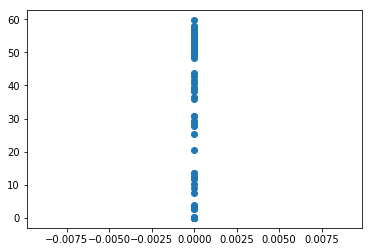

In [625]:
demand_1 = [150, 88, 125, 67, 166, 203, 90, 224, 174, 126, 66, 119, 234, 64,
            103, 77, 132, 186, 174, 239, 124, 194, 91, 228]                           
demand_2 = [200, 150, 197, 296, 191, 193, 214, 294, 247, 313, 226, 121, 197,
            242, 220, 342, 355, 320, 335, 298, 252, 222, 324, 337]
demand = [demand_1, demand_2]
N = 100
cfail = 10000
cols = ["P", "eps", "alpha", "maint", "Sfin", "unit"]
df = pd.DataFrame(columns=cols)
Q = [0.5]
tstart = time.time()
for n, q in enumerate(Q):
    Preactor = np.empty((N,0))
    inflist = []
    Nm = []
    Rfin = []
    eps = 1 - sct.norm.ppf(q=q, loc=1, scale=0.27)    
    for i in range(0,N):
        mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 3, 168,
                               ["Product_1", "Product_2"], demand, eps)
        Darr = get_deg_profile(mc, stn, j, 3, dt=1)
        inf = simulate_deg(1000, Darr, stn, j, Sinit=stn.Rinit[j])
        inflist.append(inf)
        Rfin.append(R[-1])
        Nm.append(mc.count("M-M"))
    dfloc = pd.DataFrame(inflist)
    dfloc.columns = ["P"]
    dfloc["eps"] = eps
    dfloc["alpha"] = q
    dfloc["maint"] = Nm
    dfloc["Sfin"] = Rfin 
    dfloc["unit"] = j
    dfloc["cost"] = dfloc["P"]/100*cfail + np.add(Nm, [rfin/stn.Rmax[j] for rfin in Rfin])*(stn.a[j] - stn.b[j])
    df = df.append(dfloc)
    print("j: " + j + ", eps: "+str(eps)+", P: "+ str(np.mean(inflist)))
tend = time.time() - tstart
print(tend)
j = "Still"
plt.scatter(df.loc[df["unit"] == j,"eps"],df.loc[df["unit"] == j,"P"])
#df.loc[df["unit"] == j,"maint"]

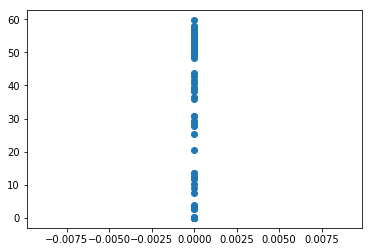

In [307]:
df.to_csv("biondiPhighD.csv")

#(Nm + [rfin/stn.Rmax[j] for rfin in Rfin])*(stn.a[j] - stn.b[j])
#Nm
#Rfin

In [127]:
cfail = 10000
df["Smax"] = [stn.Rmax[j] for j in df["unit"]]
df["costper"] = [stn.a[j] - stn.b[j] for j in df["unit"]]
df["cost"] = df["P"]/100*cfail + (df["maint"] + df["Sfin"]/[stn.Rmax[j] for j in df["unit"]])*([stn.a[j] - stn.b[j] for j in df["unit"]])

     M-M  None-None  Reaction_1-Fast  Reaction_1-Normal  Reaction_2-Fast  \
0  False      False             True               True             True   

   Reaction_2-Normal  Reaction_3-Fast  Reaction_3-Slow  
0               True             True             True  


'Reaction_3-Fast'

In [449]:
def get_logreg_list(prof):
    TP = {}
    for j in stn.units:
        for i in stn.I[j]:
            for k in stn.O[j]:
                taskmode = i+"-"+k
                TP[j, taskmode] = get_logreg(prof, taskmode, j)
        taskmode = "None-None"
        TP[j, taskmode] = get_logreg(prof, taskmode, j)
        taskmode = "M-M"
        TP[j, taskmode] = get_logreg(prof, taskmode, j)
    return TP
#TP = get_logreg_list(prof)
type(TP["Heater", "Heating-Fast"]) == str

(['None-None',
  'None-None',
  'Reaction_1-Normal',
  'Reaction_2-Normal',
  'Reaction_1-Normal',
  'Reaction_2-Normal',
  'Reaction_1-Fast',
  'Reaction_2-Normal',
  'Reaction_2-Normal',
  'None-None',
  'None-None',
  'M-M',
  'Reaction_2-Normal',
  'Reaction_3-Slow',
  'None-None',
  'None-None',
  'Reaction_1-Normal',
  'None-None',
  'None-None',
  'None-None',
  'Reaction_1-Slow',
  'Reaction_2-Slow',
  'Reaction_3-Slow',
  'Reaction_1-Normal',
  'Reaction_2-Normal',
  'Reaction_1-Normal',
  'None-None',
  'None-None',
  'None-None',
  'None-None',
  'None-None',
  'None-None',
  'None-None',
  'None-None',
  'Reaction_2-Normal',
  'Reaction_3-Slow',
  'None-None',
  'None-None',
  'Reaction_2-Normal',
  'Reaction_3-Fast',
  'Reaction_2-Normal',
  'Reaction_3-Slow',
  'None-None',
  'Reaction_1-Normal',
  'Reaction_2-Slow',
  'None-None',
  'None-None',
  'Reaction_3-Slow',
  'None-None',
  'None-None',
  'Reaction_2-Normal',
  'Reaction_3-Normal',
  'None-None',
  'Reaction_1-F

In [462]:
tstart = time.time()
simulate_deg(100000, Darr, stn, j, Sinit=stn.Rinit[j])
tend = time.time()
print(tend - tstart)

28.340410709381104


In [486]:
j = "Heater"
mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 3, 168,
                                   ["Product_1", "Product_2"], demand, eps)
Darr = get_deg_profile(mc, stn, j, 3, dt=3)
dlast = 0
dl = list()
for d in Darr[0,]:
    if d != dlast:
        dl.append(d)
    dlast = d
Darr.shape[1]/len(dl)


17.710526315789473

In [899]:
def get_short_mc(mc, t):
    slast = mc[0]
    mcshort = [mc[0]]
    tshort = []
    for i, s in enumerate(mc):
        if s != slast:
            mcshort.append(s)
            tshort.append(t[i-1])
        slast = s
    tshort.append(t[-1])
    return mcshort, tshort

def get_gradient(stn):
    GL = {}
    LL = {}
    for j in stn.units:
        for i in stn.I[j]:
            for k in stn.O[j]:
                taskmode = i + "-" + k
                GL[j, taskmode] = stn.D[i, j, k]/stn.p[i, j, k]
                LL[j, taskmode] = (0.27*stn.D[i, j, k])**2/stn.p[i,j,k]
        GL[j, "None-None"] = 0
        LL[j, "None-None"] = 0.05**2
        GL[j, "M-M"] = 0
        LL[j, "M-M"] = 0.05**2
    return GL, LL



['A']
['B', 'A']


In [2070]:
def gen_group(mc, t, sep):
    mcg = []
    tg = []
    for i, el in enumerate(mc):
        if el == sep:
            yield mcg, tg
            mcg = []
            tg = []
        mcg.append(el)
        tg.append(t[i])
    yield mcg, tg
    
def get_prob_group(mc, t, GL, LL, Nmcs=1, Sinit=0, Smax=0):
    Dm = [GL[j,tm] for tm in mc]
    Dsd = [LL[j,tm] for tm in mc]
    tdiff = [t[0]]
    tdiff += [t - s for s, t in zip(t, t[1:])]
    c = (Smax - Sinit - np.cumsum(np.multiply(tdiff,Dm)))
    c = np.insert(c, 0, Smax - Sinit)
    cm = np.divide(c[:-1], np.sqrt(Dsd))
    cm = c[:-1]
    cp = np.divide(c[1:], np.sqrt(Dsd))
    cp = c[1:]
    N = len(tdiff)
    Dsqrt = np.diag(np.sqrt(tdiff))
    #Dsqrt = Dsqrt*np.sqrt(Dsd)
    M = np.tril(np.ones((N, N), dtype=int), 0)
    hl = []
    for n in range(0, Nmcs):
        u = np.random.normal(size=(N,1))
        u =  np.random.normal(scale=np.sqrt(Dsd))
        A =  M @ Dsqrt @ u
        xp = cp + A
        xm = cp + A
        xm = np.insert(xm,0,cm[0])
        #ind = [xi > 0 for xi in x]
        ind = [xi > 0 for xi in xp]
        
    
        h = 1
        for i in range(0, N):
            if ind[i]:                
                #h *= (1-np.exp(-2*x[i]*x[i+1]/(tdiff[i])))
                h *= (1-np.exp(-2*xm[i]*xp[i]/(Dsd[i]*tdiff[i])))
                #print(-2*x[i]*x[i+1]/tdiff[i])
            else:
                h = 0
        hl.append(h)
    #print(hl)
    return 1 - np.mean(hl)
    
def get_prob(mc, t, GL, LL, Nmcs=1, Sinit=0, S0=0, Smax=0):
    J = 1
    for mcg, tg in gen_group(mc, t, "M-M"):
        J *= 1 - get_prob_group(mcg, tg, GL, LL, Nmcs, Sinit=Sinit, Smax=Smax)
        Sinit = S0
    return 1 - J
j = "Reactor_1"
mc, R, t = simulate_mc(TP, stn, j, "None-None", 168*12, 3, 168,
                                   ["Product_1", "Product_2"], demand, eps)

mcshort, tshort = get_short_mc(mc, t)
GL, LL = get_gradient(stn)
ts = time.time()
p = get_prob(mcshort, tshort, GL, LL, Nmcs=100000, Sinit=stn.Rinit[j], S0=0, Smax=stn.Rmax[j])
print(time.time() - ts)
Darr = get_deg_profile(mc, stn, j, 3, dt=1)
ts = time.time()
inf = simulate_deg(100000, Darr, stn, j, Sinit=stn.Rinit[j])
print(time.time() - ts)
print(p*100, inf)
#len(mc)/len(mcshort)

59.875303506851196
36.62947368621826
84.71083162678967 84.08200000000001


In [2065]:
j = "Reactor_1"
mcshort = ["Reaction_1-Normal"]
tshort = [165]
c0 = 50
c1 = c0 - tshort[0]*mue
mc = ["Reaction_1-Normal" for i in range(0, tshort[0]//15)]
t = [15*(i+1) for i in range(0, tshort[0]//15)]
mc.append("M-M")
t.append(t[-1]+21)
mc += mc
t += list(np.add(t, t[-1]))
Darr = get_deg_profile(mc, stn, j, 3, dt=1/1)
#Darr[1] = 1
l = LL["Reactor_1", mcshort[0]]
mue = GL["Reactor_1", mcshort[0]]

In [2068]:
pl = []
xl = []
ts = time.time()
for n in range(0,100000):
    u1 = np.random.normal()
    x1 = np.random.normal(scale=np.sqrt(l*tshort[0]))
    x1 = c1/np.sqrt(l) + u1*np.sqrt(tshort[0])
    x1 = c1 + u1*np.sqrt(l*tshort[0])
    #x1 = np.random.normal(scale=np.sqrt(tshort[0]))    
    if x1 > 0: # c1/np.sqrt(l):
        #print(-2*c0/np.sqrt(l)*x1/tshort[0])
        #pl.append(1 - np.exp(-2*(c0/np.sqrt(l))*(x1)/tshort[0]))
        pl.append(1 - np.exp(-2*(c0)*(x1)/(tshort[0]*l)))
    else:
        pl.append(0)
print("Time taken:", time.time()-ts)
print(1 - np.mean(pl))
ts = time.time()
inf = simulate_deg(10000, Darr, stn, j, Sinit=stn.Rinit[j])/100
print("Time taken:", time.time()-ts)
print(inf)
print(1 - sct.norm.cdf((-mue*tshort[0]+50)/np.sqrt(tshort[0]), scale=np.sqrt(l)) + np.exp(2*mue*50)*sct.norm.cdf((-mue*tshort[0]-50)/np.sqrt(tshort[0]), scale=np.sqrt(l)))

Time taken: 0.7937338352203369
0.8770380051577449
Time taken: 1.161067247390747
0.8745
0.8679405481131369


In [2069]:
mc

['Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'M-M',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'Reaction_1-Normal',
 'M-M']